In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imported modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage import io
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import xception
from keras import models, layers, optimizers
from keras.utils.np_utils import to_categorical
import os
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns

### DATA COLLECTION AND PREPROCESSING



> ### Metadata CSV file processing



In [ ]:
# Reading the HAM10000 metadata file
data = pd.read_csv('./drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
data["number"] = data["image_id"].str.split("_").str[1].astype(int)
data["Folder"] = np.where((data["number"] >= 24306) & (data["number"] < 29306),
                                "HAM10000_images_part_1",
                                "HAM10000_images_part_2")
data = data.sort_values("number")
data.drop(["lesion_id","dx_type","age","sex","localization"], axis=1, inplace=True)
data = data.reset_index(drop=True)
data

,image_id,dx,number,Folder
0,ISIC_0024306,nv,24306,HAM10000_images_part_1
1,ISIC_0024307,nv,24307,HAM10000_images_part_1
2,ISIC_0024308,nv,24308,HAM10000_images_part_1
3,ISIC_0024309,nv,24309,HAM10000_images_part_1
4,ISIC_0024310,mel,24310,HAM10000_images_part_1
...,...,...,...,...
10010,ISIC_0034316,mel,34316,HAM10000_images_part_2
10011,ISIC_0034317,mel,34317,HAM10000_images_part_2
10012,ISIC_0034318,bkl,34318,HAM10000_images_part_2
10013,ISIC_0034319,nv,34319,HAM10000_images_part_2


In [ ]:
labels_dict = {
    0: "nv",
    1: "mel",
    2: "bkl",
    3: "bcc",
    4: "akiec",
    5: "vasc",
    6: "df"
}

In [ ]:
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
data['lesion_ID'] = data['dx'].map(lesion_ID_dict)
data.head()

,image_id,dx,number,Folder,lesion_ID
0,ISIC_0024306,nv,24306,HAM10000_images_part_1,0
1,ISIC_0024307,nv,24307,HAM10000_images_part_1,0
2,ISIC_0024308,nv,24308,HAM10000_images_part_1,0
3,ISIC_0024309,nv,24309,HAM10000_images_part_1,0
4,ISIC_0024310,mel,24310,HAM10000_images_part_1,1




> ### PROCESSING AND RESIZING IMAGES



In [ ]:
# x = []
# y = []
# iterations = 10015
# folders = data["Folder"].values
# images = [img_file+".jpg" for img_file in data["image_id"].values]
# img_id_lst = list(zip(folders,images))

# for i in tqdm(range(iterations)):
#   file_to_read = './drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/'+img_id_lst[i][0]+'/'+img_id_lst[i][1]
#   img = cv2.imread(file_to_read)
#   img2 = cv2.resize(img, (224, 224))
#   x.append(img2)

#   fname_ID = img_id_lst[i][1].split('.')[0]

#   output = np.array(data[data['image_id'] == fname_ID]["lesion_ID"])
#   y.append(output[0])


In [ ]:
# np.save('./drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/resized_images.npy',x)
# np.save('./drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/lesion_IDs.npy',y)



> ### SPLITTING THE DATA INTO TRAINING, TEST AND VALIDATION SETS



In [ ]:
x = np.load('./drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/resized_images.npy')
y = np.load('./drive/MyDrive/Dissertation/skin-cancer-mnist-ham10000/lesion_IDs.npy')

y_train = to_categorical(y, num_classes = 7)

X_train, X_test, y_train, y_test = train_test_split(x,y_train,                            
                                                    test_size = 0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.10, random_state=42)




> ### GENERATING HELPER DATAFRAME FOR THE TRAINING SET



In [ ]:
dx = [labels_dict[index] for index in np.argmax(y_train, axis=1)]
lesion_ID = np.argmax(y_train,axis=1)
image_index = np.arange(len(y_train))

training_set_df = pd.DataFrame({
    'image_index': image_index,
    'dx': dx,
    'lesion_ID': lesion_ID
})
training_set_df

,image_index,dx,lesion_ID
0,0,nv,0
1,1,bkl,2
2,2,nv,0
3,3,akiec,4
4,4,akiec,4
...,...,...,...
7205,7205,nv,0
7206,7206,bkl,2
7207,7207,nv,0
7208,7208,bkl,2


### MODEL TRAINING



> ### INPUT SHAPE, NUMBER OF CLASSES, LESION TYPES



In [ ]:
input_shape = (224,224,3)
number_of_classes = 7
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_abrev = ['nv','mel','bkl','bcc','akiec','vasc','df']



> ### USEFUL FUNCTIONS



In [ ]:
def mod_checkpoint_callback() -> None:
    
    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,     
                             monitor = 'val_accuracy',      
                             mode = 'auto',                 
                             save_best_only = True,     
                             verbose = 1)
    return trained_model

def display_accuracy(history,epochs) -> None:
    # Summarize history for accuracy
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'g')
    plt.title('model accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.xlim(0,epochs)
    plt.show()
    
    
def display_loss(history,epochs) -> None:
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(history.history['loss'],'b')
    plt.plot(history.history['val_loss'], 'g')
    plt.title('model loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlim(0,epochs)
    plt.show()

def test_model(y_ground_truth,y_pred) -> tuple:
    """ Tunning the accurate results and inaccurate results

    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_ground_truth[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)


> ### DENSENET121 MODEL



In [ ]:
densenet_base_model = densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in densenet_base_model.layers:
  layer.trainable=False

densenet_inputs = layers.Input(shape=input_shape)
densenet_x = densenet.preprocess_input(densenet_inputs)
densenet_x = densenet_base_model(densenet_x,training=False)
densenet_x = layers.GlobalAveragePooling2D()(densenet_x)
# densenet_x = layers.Dense(256, activation='relu')(densenet_x)
# densenet_x = layers.Dropout(0.5)(densenet_x)
densenet_predictions = layers.Dense(number_of_classes, activation='softmax')(densenet_x)

densenet_model = models.Model(inputs=densenet_inputs, outputs=densenet_predictions)
densenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
densenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                           

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 5, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

train_datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 32
epochs = 1

densenet_history = densenet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

226/226 [==============================] - ETA: 0s - loss: 1.0319 - accuracy: 0.6602
Epoch 1: val_accuracy improved from -inf to 0.70449, saving model to model.h5
226/226 [==============================] - 85s 317ms/step - loss: 1.0319 - accuracy: 0.6602 - val_loss: 0.8076 - val_accuracy: 0.7045


In [ ]:
for layer in densenet_base_model.layers:
  layer.trainable=True

densenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
densenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 5, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()
batch_size = 32
epochs = 30

### FITTING THE DENSENET MODEL WITH 30 EPOCHS
densenet_history = densenet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

Epoch 1/30
226/226 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.7040
Epoch 1: val_accuracy improved from -inf to 0.73317, saving model to model.h5
226/226 [==============================] - 90s 330ms/step - loss: 0.8368 - accuracy: 0.7040 - val_loss: 0.6627 - val_accuracy: 0.7332
Epoch 2/30
226/226 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7540
Epoch 2: val_accuracy improved from 0.73317 to 0.77805, saving model to model.h5
226/226 [==============================] - 71s 313ms/step - loss: 0.6882 - accuracy: 0.7540 - val_loss: 0.6103 - val_accuracy: 0.7781
Epoch 3/30
226/226 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.7667
Epoch 3: val_accuracy improved from 0.77805 to 0.78928, saving model to model.h5
226/226 [==============================] - 70s 311ms/step - loss: 0.6391 - accuracy: 0.7667 - val_loss: 0.5649 - val_accuracy: 0.7893
Epoch 4/30
226/226 [==============================] - ETA: 0s - loss: 

In [ ]:
scores = densenet_model.evaluate(X_val, y_val, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

26/26 [==============================] - 2s 19ms/step - loss: 0.4388 - accuracy: 0.8591
Accuracy: 85.91%


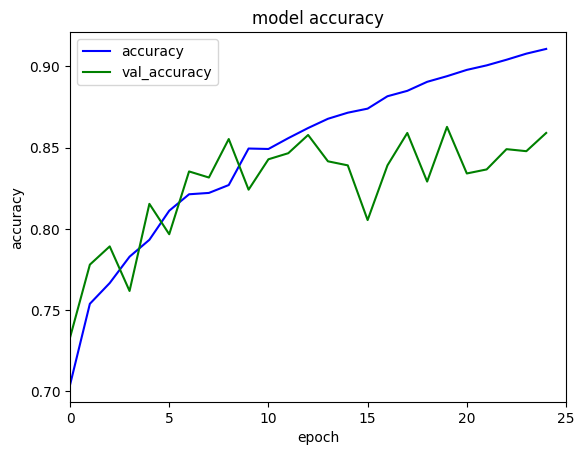

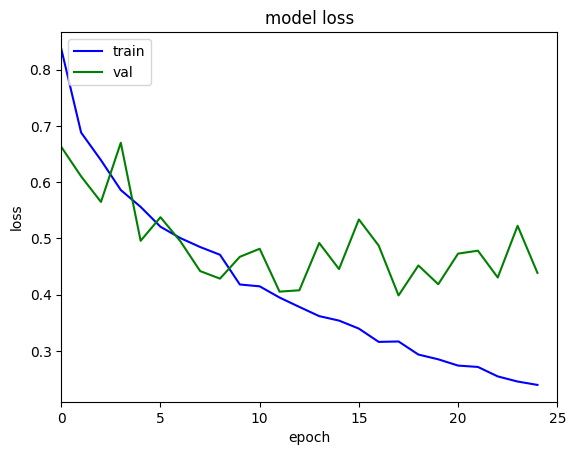

In [ ]:
display_accuracy(densenet_history,25)
display_loss(densenet_history,25)

In [ ]:
y_pred = densenet_model.predict(X_test)
total, accurate = test_model(y_test,y_pred)
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

63/63 [==============================] - 1s 17ms/step
Total-test-data; 2003 	accurately-predicted-data: 1686 	 wrongly-predicted-data:  317
Accuracy: 84.174 %


In [ ]:
best_model = load_model('./model.h5')

# Compute predictions
densenet_y_pred_prob = np.around(best_model.predict(X_test),3)
densenet_y_pred = np.argmax(densenet_y_pred_prob, axis = 1)
densenet_y_test2 = np.argmax(y_test, axis = 1)

63/63 [==============================] - 3s 17ms/step


In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.3f%%" % (scores[1] * 100))

63/63 [==============================] - 3s 19ms/step - loss: 0.4730 - accuracy: 0.8417
Accuracy: 84.174%


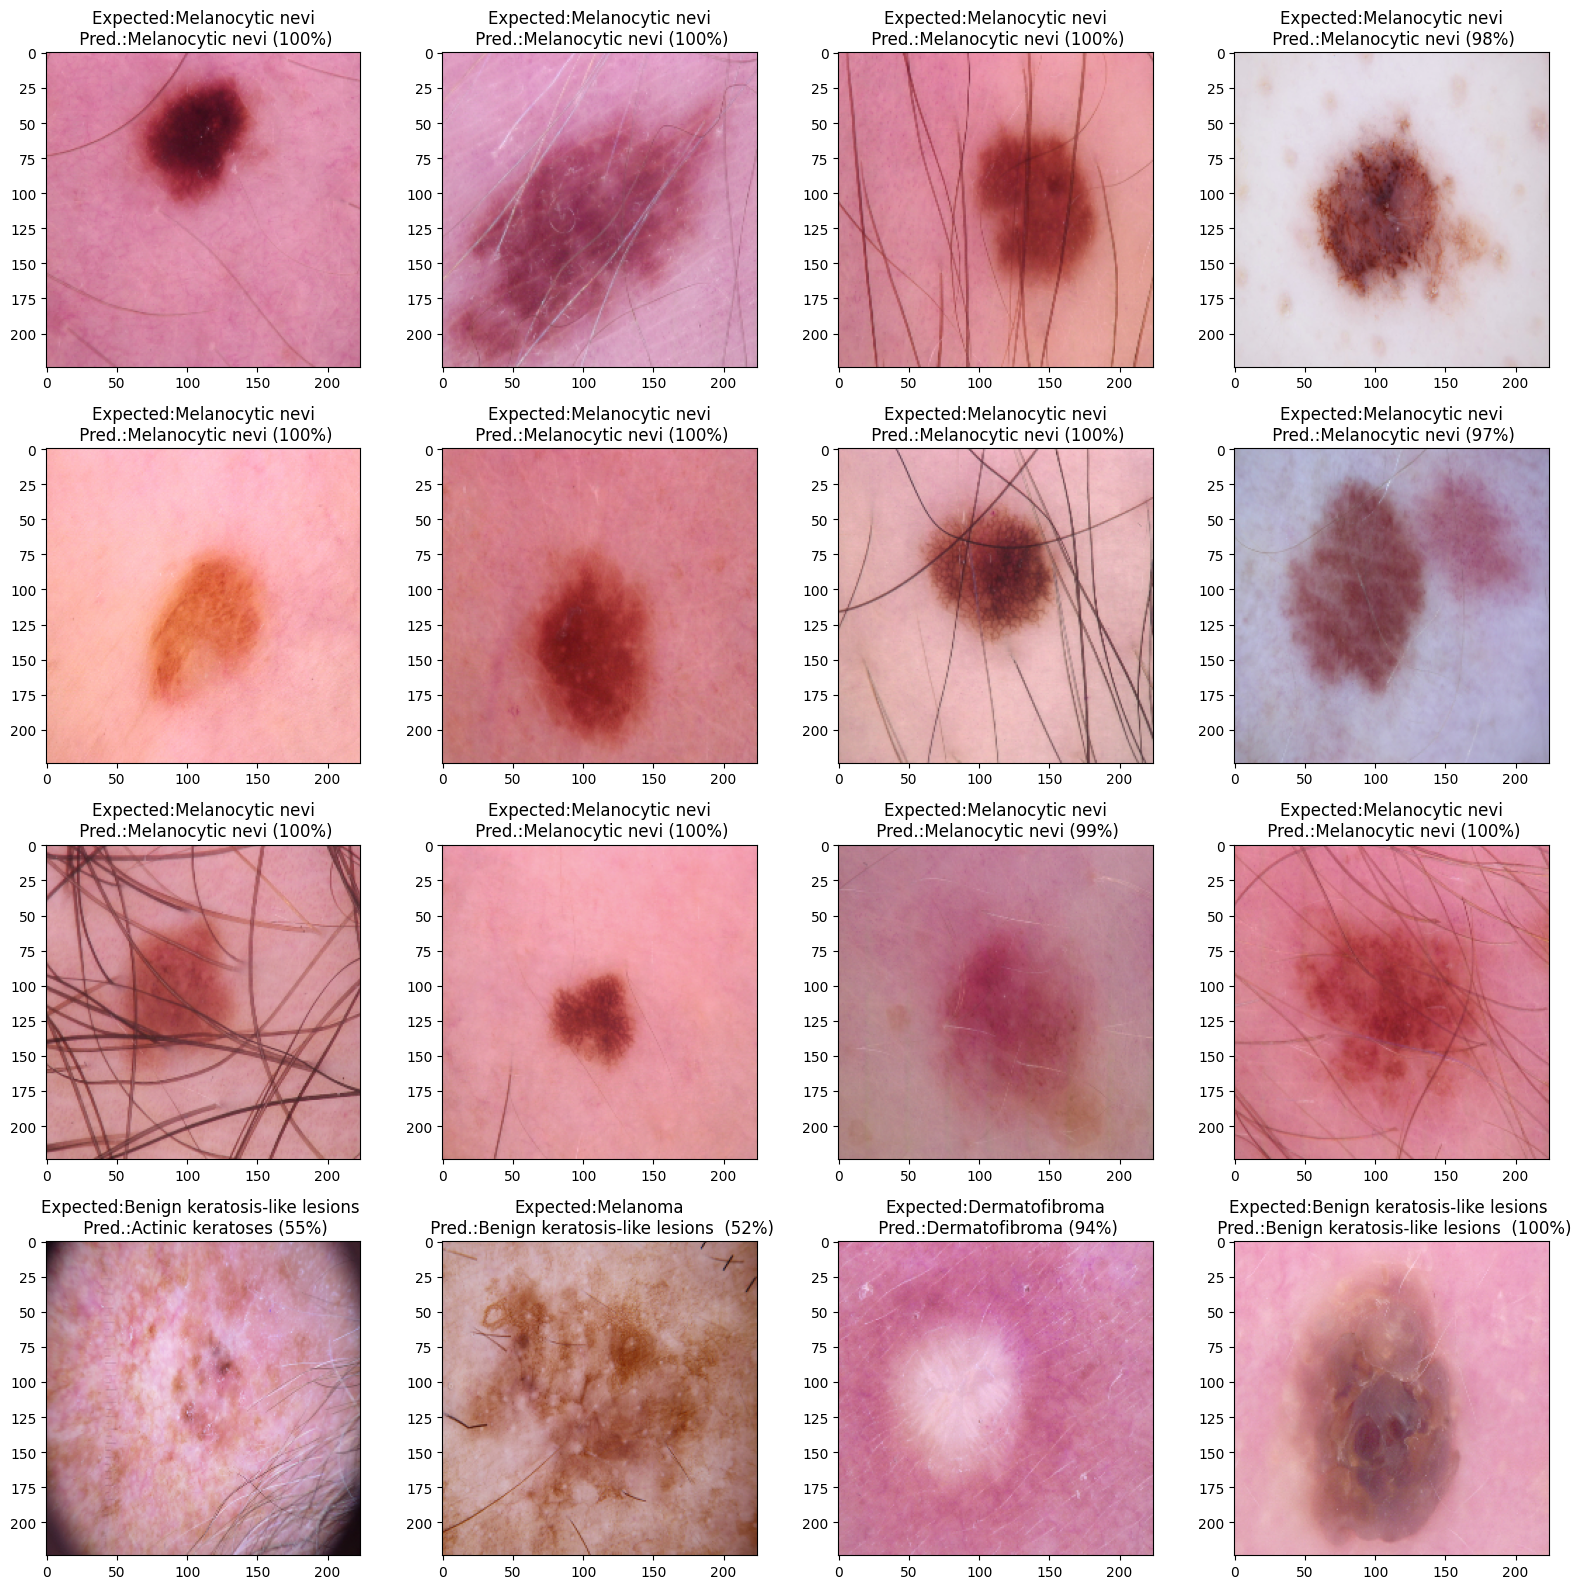

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[densenet_y_test2[index]]  #expected label
    label_pred = lesion_names[densenet_y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(densenet_y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()



> ### RESNET50 MODEL



In [ ]:
# Load the pre-trained ResNet50 model
resnet_base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers in the pre-trained model
for layer in resnet_base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
resnet_inputs = layers.Input(shape=input_shape)
resnet_x = resnet50.preprocess_input(resnet_inputs)
resnet_x = resnet_base_model(resnet_x,training=False)
resnet_x = layers.AveragePooling2D()(resnet_x)
resnet_x = layers.Flatten()(resnet_x)
resnet_x = layers.Dense(128, activation='relu')(resnet_x)
resnet_x = layers.Dropout(0.3)(resnet_x)
resnet_predictions = layers.Dense(number_of_classes, activation='softmax')(resnet_x)

resnet_model = models.Model(inputs=resnet_inputs, outputs=resnet_predictions)
resnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                  

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 3, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


train_datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 32
epochs = 1


### FITTING RESNET MODEL WITH 35 EPOCHS
resnet_history = resnet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

In [ ]:
for layer in resnet_base_model.layers:
  layer.trainable=True

resnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model.summary()

In [ ]:
epochs=30
resnet_history = resnet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

In [ ]:
scores = resnet_model.evaluate(X_val, y_val, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

26/26 [==============================] - 1s 16ms/step - loss: 0.5347 - accuracy: 0.8392
Accuracy: 83.92%


In [ ]:
display_accuracy(resnet_history,16)
display_loss(resnet_history,16)

In [ ]:
y_pred = resnet_model.predict(X_test)
total, accurate = test_model(y_test,y_pred)
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

In [ ]:
best_model = load_model('./model.h5')

# Compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()



> ### XCEPTION MODEL 



In [ ]:
xceptionnet_base_model = xception.Xception(include_top=False,weights='imagenet',input_shape = input_shape)
for layer in xceptionnet_base_model.layers:
  layer.trainable=False
# Add custom classification layers on top of the pre-trained model
xceptionnet_inputs = layers.Input(shape=input_shape)
xceptionnet_x = xception.preprocess_input(xceptionnet_inputs)

xceptionnet_x = xceptionnet_base_model(xceptionnet_x,training=False)
xceptionnet_x = layers.Flatten()(xceptionnet_x)

xceptionnet_x = layers.BatchNormalization()(xceptionnet_x)
xceptionnet_x = layers.Dense(128, activation='relu')(xceptionnet_x)
xceptionnet_x = layers.Dropout(0.5)(xceptionnet_x)

xceptionnet_x = layers.BatchNormalization()(xceptionnet_x)
xceptionnet_predictions = layers.Dense(number_of_classes, activation='softmax')(xceptionnet_x)

xceptionnet_model = models.Model(inputs=xceptionnet_inputs, outputs=xceptionnet_predictions)
xceptionnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
xceptionnet_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                            

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 5, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

# train_datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, vertical_flip=True
#                                    ,shear_range = 0.3, rotation_range=90, 
#                                    width_shift_range=0.1, height_shift_range=0.1) 

train_datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 32
epochs = 1


xceptionnet_history = xceptionnet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

In [ ]:
for layer in xceptionnet_base_model.layers:
  layer.trainable=True

xceptionnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
xceptionnet_model.summary()

In [ ]:
epochs=30
xceptionnet_history = xceptionnet_model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                    epochs = epochs,
                    batch_size = batch_size,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = val_datagen.flow(X_val, y_val),
                )

In [ ]:
scores = xceptionnet_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
display_accuracy(xceptionnet_history,15)
display_loss(xceptionnet_history,15)

In [ ]:
y_pred = xceptionnet_model.predict(X_test)
total, accurate = test_model(y_test,y_pred)
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

In [ ]:
best_model_2 = load_model('./model.h5')

# Compute predictions
y_pred_prob_2 = np.around(best_model_2.predict(X_test),3)
y_pred_2 = np.argmax(y_pred_prob_2, axis = 1)
y_test2_2 = np.argmax(y_test, axis = 1)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_2.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))



> ### CONFUSION MATRICES






> ### Plot function





In [ ]:
def plot(y_true,y_pred):
  labels = unique_labels(y_true)
  columns = [labels_dict[label] for label in labels]
  indices = [labels_dict[label] for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true,y_pred),
                       columns=columns,index=indices)
  
  return table



> > ### DENSENET121 RESULTS



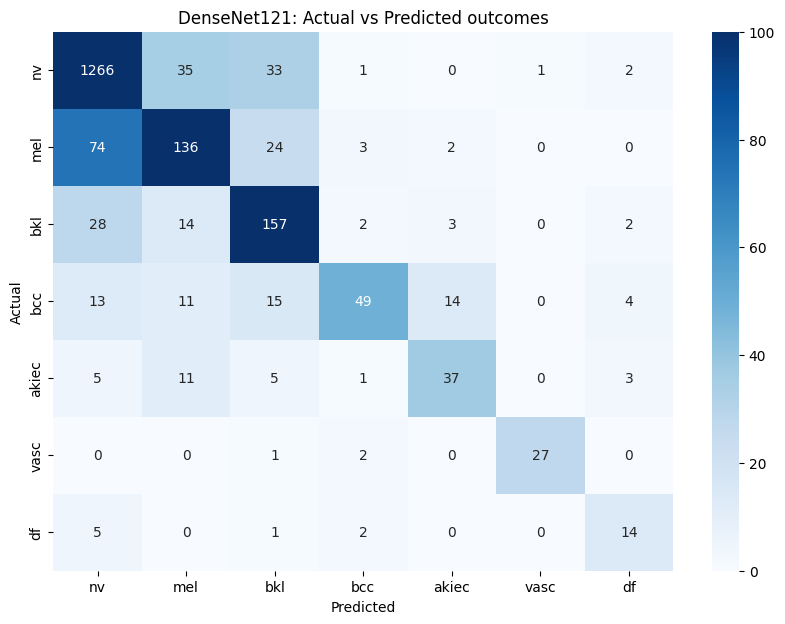

In [ ]:
plt.figure(figsize=(10,7))
plt.title("DenseNet121: Actual vs Predicted outcomes")
sns.heatmap(plot(densenet_y_test2,densenet_y_pred),annot=True, fmt='g', vmin = 0, vmax = 100, cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

densenet_report = classification_report(densenet_y_test2,densenet_y_pred)
print(densenet_report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1338
           1       0.66      0.57      0.61       239
           2       0.67      0.76      0.71       206
           3       0.82      0.46      0.59       106
           4       0.66      0.60      0.63        62
           5       0.96      0.90      0.93        30
           6       0.56      0.64      0.60        22

    accuracy                           0.84      2003
   macro avg       0.75      0.70      0.71      2003
weighted avg       0.84      0.84      0.84      2003





> > ### RESNET121 RESULTS



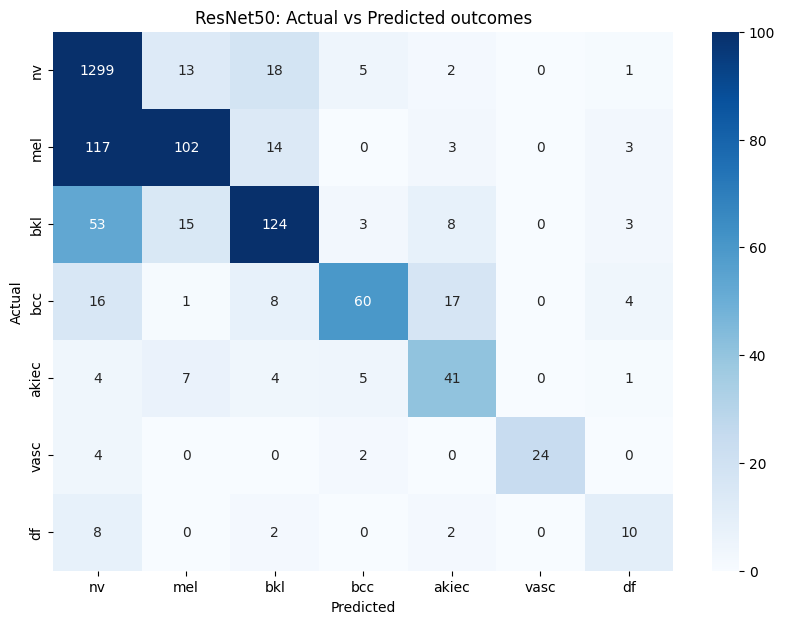

In [ ]:
plt.figure(figsize=(10,7))
plt.title("ResNet50: Actual vs Predicted outcomes")
sns.heatmap(plot(y_test2,y_pred),annot=True, fmt='g', vmin = 0, vmax = 100, cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

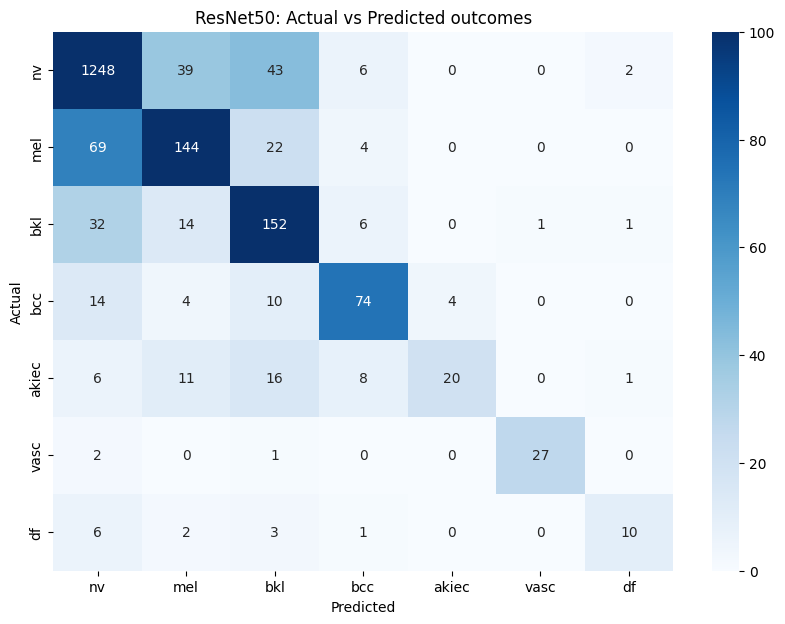

In [ ]:
plt.figure(figsize=(10,7))
plt.title("ResNet50: Actual vs Predicted outcomes")
sns.heatmap(plot(y_test2,y_pred),annot=True, fmt='g', vmin = 0, vmax = 100, cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

resnet_report = classification_report(y_test2,y_pred)
print(resnet_report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1338
           1       0.67      0.60      0.64       239
           2       0.62      0.74      0.67       206
           3       0.75      0.70      0.72       106
           4       0.83      0.32      0.47        62
           5       0.96      0.90      0.93        30
           6       0.71      0.45      0.56        22

    accuracy                           0.84      2003
   macro avg       0.78      0.66      0.70      2003
weighted avg       0.84      0.84      0.83      2003





> > ### XCEPTION RESULTS









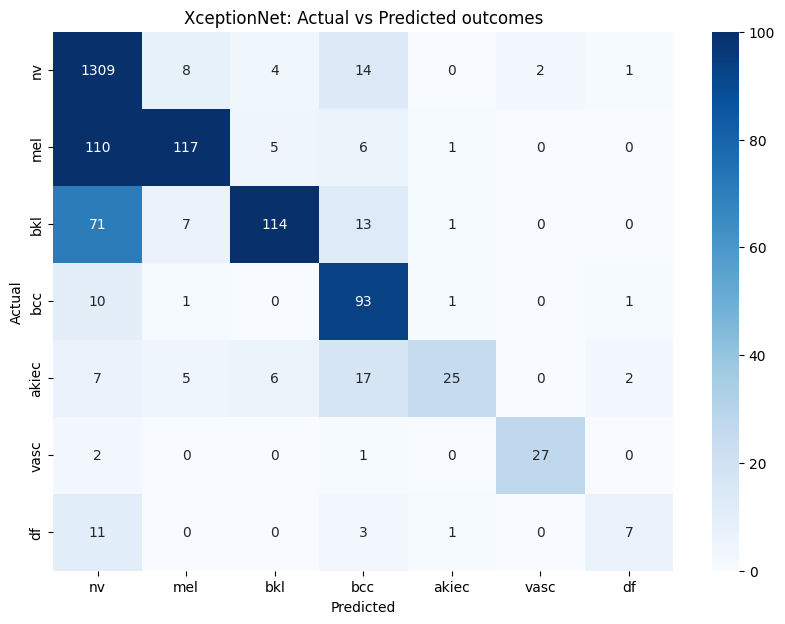

In [ ]:
plt.figure(figsize=(10,7))
plt.title("XceptionNet: Actual vs Predicted outcomes")
sns.heatmap(plot(y_test2_2,y_pred_2),annot=True, fmt='g', vmin = 0, vmax = 100, cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

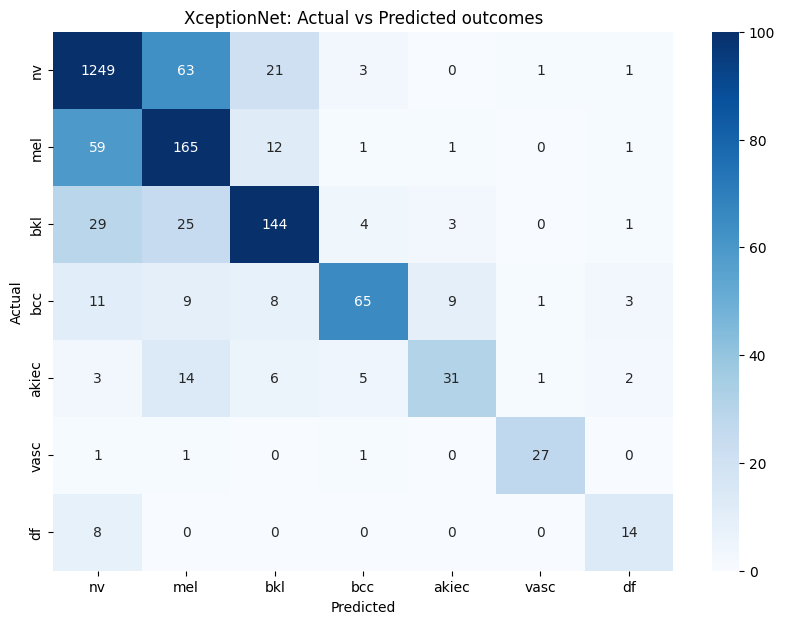

In [ ]:
plt.figure(figsize=(10,7))
plt.title("XceptionNet: Actual vs Predicted outcomes")
sns.heatmap(plot(y_test2_2,y_pred_2),annot=True, fmt='g', vmin = 0, vmax = 100, cmap ='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

resnet_report = classification_report(y_test2_2,y_pred_2)
print(resnet_report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1338
           1       0.60      0.69      0.64       239
           2       0.75      0.70      0.73       206
           3       0.82      0.61      0.70       106
           4       0.70      0.50      0.58        62
           5       0.90      0.90      0.90        30
           6       0.64      0.64      0.64        22

    accuracy                           0.85      2003
   macro avg       0.76      0.71      0.73      2003
weighted avg       0.85      0.85      0.85      2003

